In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import random
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import loglaplace, lognorm, laplace, norm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.special import erf
warnings.filterwarnings('ignore')
sns.set(style="white", context="talk")
from matplotlib import rc
#plt.rc('text', usetex=True)

np.random.seed(42)

## S3.2 Simulating the main proposition

The lower bound on the probability that a centerlized network will outperform a decenterlized structure:

$$
\begin{align}
    {\bf Proposition.~} \Omega^{\theta}_n(\omega,{\mu,\sigma}) \geq \displaystyle\sup_{\beta>\theta/(1-\omega)} \left\{ F^{\theta}_{\mu,\sigma}(\beta)(1 - {F}^{\theta}_{\mu,\sigma}(n\beta)^{n-1})\right\}.
\end{align}
$$

In [26]:
n = 100
θ = 2
μ_ = np.linspace(-3,3,10)
σ_ = np.logspace(-1,1,21)
ω = 1/3 #(n-2)/(3*n - 2)
print(ω)

0.3333333333333333


In [27]:
def β_min(θ,ω,μ):
    return np.max([θ/(1-ω),μ])

In [28]:
def plot_lower_bound(μμ,σσ,data,save=False,title=""):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.set_yscale('log',basey=10)


    main_cs = ax.contourf(μμ,σσ,data.T,levels=np.linspace(0,1,25),cmap='RdYlBu')
    cbar = fig.colorbar(main_cs, ticks=np.linspace(0,1,5))
    
    cbar.ax.set_title("Ω",fontsize=40)

    ##Label the body of the plot
    ax.set_xlabel("Systematic bias, μ",fontsize=30)
    ax.set_ylabel('Dispersion, σ',fontsize=30)

    #ax.set_xlim(-2.99,2.99)
    ax.set_ylim(0.1,10)
    ax.tick_params(labelsize=30)

    ax.set_yticks((0.1,1,10))
    ax.set_yticklabels((0.1,1,10))

    if save:
        plt.savefig('./mini_bound'+str(title)+'.pdf', bbox_inches='tight')

#### Pareto

In [29]:
def pareto(x,μ,σ):
    return (θ*np.exp(μ)/x)**σ

In [30]:
def F(β,μ,σ,n):
    α = 1/σ
    F_term = (1-pareto(β,μ,α))
    other_term = 1 - (1-pareto(n*β,μ,α))**(n-1)
    return F_term*other_term

In [31]:
def find_max(μ,σ,n,multiple = 10.0):
    βmin = β_min(θ,ω,μ)
    x = np.linspace(βmin, multiple*βmin,1000)
    F_ = F(x,μ,σ,n)
    max_ = np.max(F_)
    if(np.allclose(F_ - max_ , np.zeros(1000))):
        return max_
    if max_ == F_[-1]:
        new_multiple = multiple*10.0
        max_ = find_max(μ,σ,n,multiple = new_multiple)
    return max_

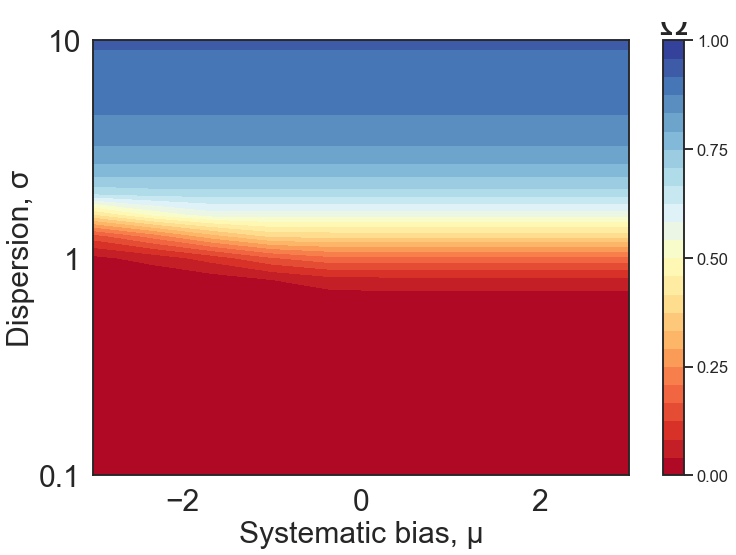

In [32]:

Ω_pareto = np.zeros([len(μ_),len(σ_)])
for i,μ in enumerate(μ_):
    for j,σ in enumerate(σ_):
        Ω_pareto[i,j] = find_max(μ,σ,n)
        
Ω_pareto[np.isnan(Ω_pareto)] = 0.0
        
sigma = 0
data = gaussian_filter(Ω_pareto, sigma)
μμ,σσ = np.meshgrid(μ_,σ_) 

plot_lower_bound(μμ,σσ,data,save=True,title="Pareto")

#### Lognormal

In [33]:
def F_lognorm(β,μ,σ,n):
    F_term = 0.5 + 0.5*erf((np.log(β) - μ)/σ/np.sqrt(2))
    other_term = 1 - (0.5 + 0.5*erf((np.log(n*β) - μ)/σ/np.sqrt(2)))**(n-1)
    return F_term*other_term

In [34]:
def find_max_lognorm(μ,σ,n,multiple = 10.0):
    βmin = β_min(θ,ω,μ)
    x = np.linspace(βmin, multiple*βmin,1000)
    F_ = F_lognorm(x,μ,σ,n)
    max_ = np.max(F_)
    if(np.allclose(F_ - max_ , np.zeros(1000))):
        return max_
    if max_ == F_[-1]:
        new_multiple = multiple*10.0
        max_ = find_max_lognorm(μ,σ,n,multiple = new_multiple)
    return max_

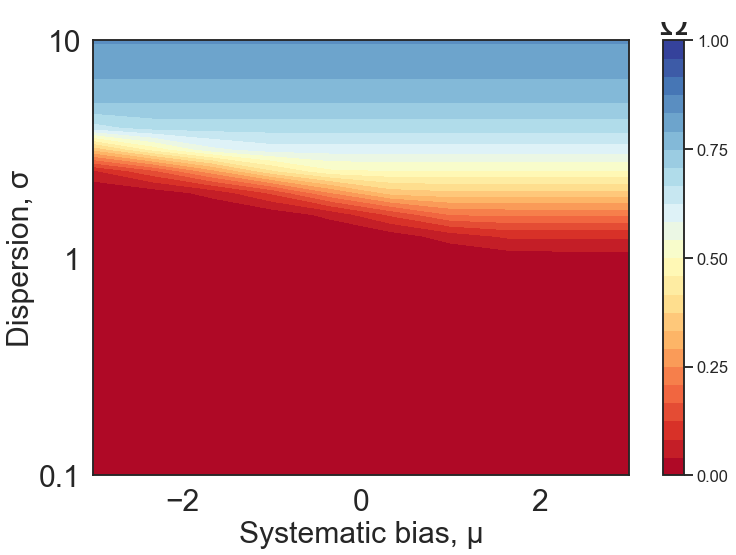

In [35]:
n = 50
θ = 2
μ_ = np.linspace(-3,3,10)
σ_ = np.logspace(-1,1,21)
ω = (n-2)/(3*n - 2)

Ω_lognorm = np.zeros([len(μ_),len(σ_)])
for i,μ in enumerate(μ_):
    for j,σ in enumerate(σ_):
        Ω_lognorm[i,j] = find_max_lognorm(μ+np.log(θ),σ,n)
        
sigma = 0
data = gaussian_filter(Ω_lognorm, sigma)
μμ,σσ = np.meshgrid(μ_,σ_) 


plot_lower_bound(μμ,σσ,data,save=True,title="Lognormal")

#### Loglaplace

In [36]:
def LogLaplaceCDF(x,θ,μ,σ):
    if np.log(x/θ) < μ:
        return 0.5*np.exp((np.log(x/θ) - μ)/σ)
    else:
        return 1 - 0.5*np.exp((μ - np.log(x/θ))/σ)

def F_loglaplace(β,θ,μ,σ,n):
    F_term = LogLaplaceCDF(β,θ,μ,σ)
    other_term = 1 - (LogLaplaceCDF(β*n,θ,μ,σ))**(n-1)
    return F_term*other_term

In [37]:
def find_max_loglaplace(θ,μ,σ,n,multiple = 10.0):
    βmin = β_min(θ,ω,μ)
    x = np.linspace(βmin, multiple*βmin,1000)
    F_ = np.asarray([F_loglaplace(y,θ,μ,σ,n) for y in x])
    max_ = np.max(F_)
    if(np.allclose(F_ - max_ , np.zeros(1000))):
        return max_
    if max_ == F_[-1]:
        new_multiple = multiple*10.0
        max_ = find_max_loglaplace(θ,μ,σ,n,multiple = new_multiple)
    return max_

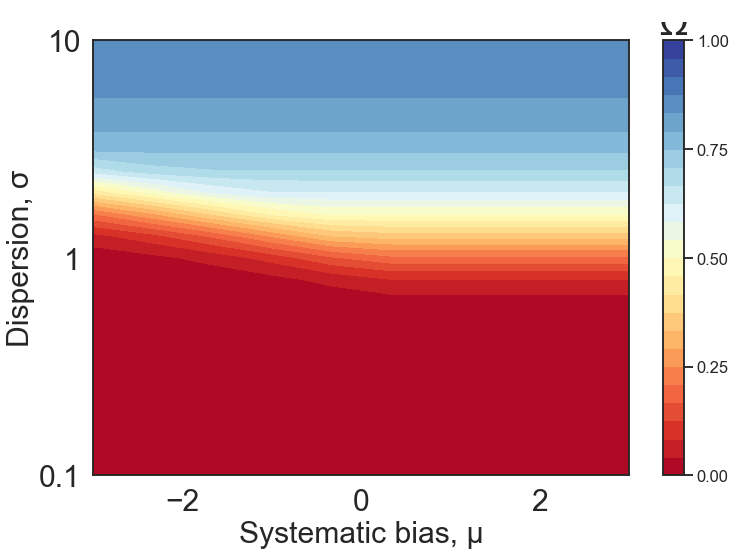

In [38]:
Ω_loglaplace = np.zeros([len(μ_),len(σ_)])
for i,μ in enumerate(μ_):
    for j,σ in enumerate(σ_):
        Ω_loglaplace[i,j] = find_max_loglaplace(θ,μ,σ,n)
        
sigma = 0
data = gaussian_filter(Ω_loglaplace, sigma)
μμ,σσ = np.meshgrid(μ_,σ_) 

plot_lower_bound(μμ,σσ,data,save=True,title="Log-Laplace")

#### Folded Gaussian

In [39]:
def GaussianCDF(x,θ,μ,σ):
    return 0.5*(erf((x - (θ*np.exp(μ)))/σ/np.sqrt(2)) + erf((x + (θ*np.exp(μ)))/σ/np.sqrt(2)))

def F_Gaussian(β,θ,μ,σ,n):
    F_term = GaussianCDF(β,θ,μ,σ)
    other_term = 1 - (GaussianCDF(β*n,θ,μ,σ))**(n-1)
    return F_term*other_term

In [40]:
def find_max_Gaussian(θ,μ,σ,n,multiple = 10.0):
    βmin = β_min(θ,ω,μ)
    x = np.linspace(βmin, multiple*βmin,1000)
    F_ = np.asarray([F_Gaussian(y,θ,μ,σ,n) for y in x])
    max_ = np.max(F_)
    if(np.allclose(F_ - max_ , np.zeros(1000))):
        return max_
    if max_ == F_[-1]:
        new_multiple = multiple*10.0
        max_ = find_max_Gaussian(θ,μ,σ,n,multiple = new_multiple)
    return max_

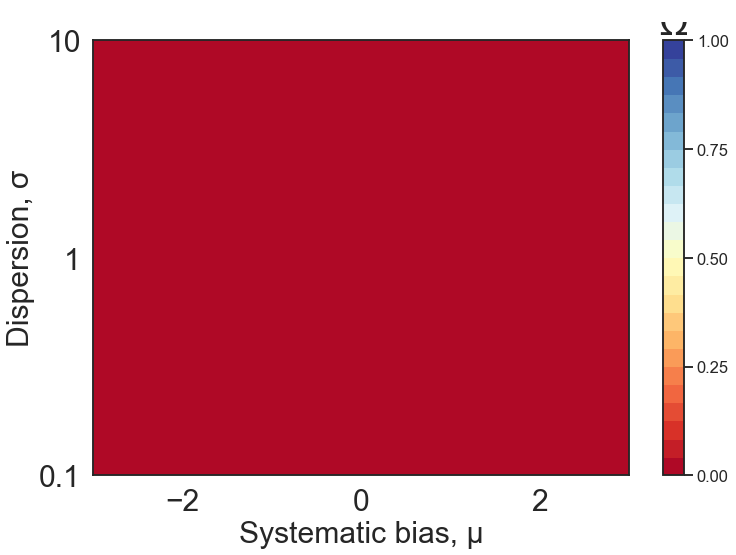

In [41]:
Ω_gaussian = np.zeros([len(μ_),len(σ_)])
for i,μ in enumerate(μ_):
    for j,σ in enumerate(σ_):
        Ω_gaussian[i,j] = find_max_Gaussian(θ,μ,σ,n)
        
sigma = 0
data = gaussian_filter(Ω_gaussian, sigma)
μμ,σσ = np.meshgrid(μ_,σ_) 

plot_lower_bound(μμ,σσ,data,save=True,title="Folded Gaussian")